# Demonstration of linear Kalman filter


This notebook demonstrates the use of a linear Kalman filter to recover the underling state evolution of a pulsar frequency timeseries.

It also discusses the use of likelihood methods for parameter estimation

In [182]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [183]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

## 1. Single run example - true parameters


We can generate some synthetic data, and run the Kalman filter to see how well we recover the state.

The Kalman filter depends on a series of physical parameters (e.g. GW angular frequency). 

Lets assume we know these perfectly, and see how the filter does.

In [184]:
from system_parameters import SystemParameters
from pulsars import Pulsars

from synthetic_data import SyntheticData
from plotting import plot_statespace,plot_all
from model import LinearModel
from kalman_filter import KalmanFilter
from bilby_wrapper import BilbySampler
from priors import priors_dict,bilby_priors_dict

Model likelihood is:  528814.2784771026


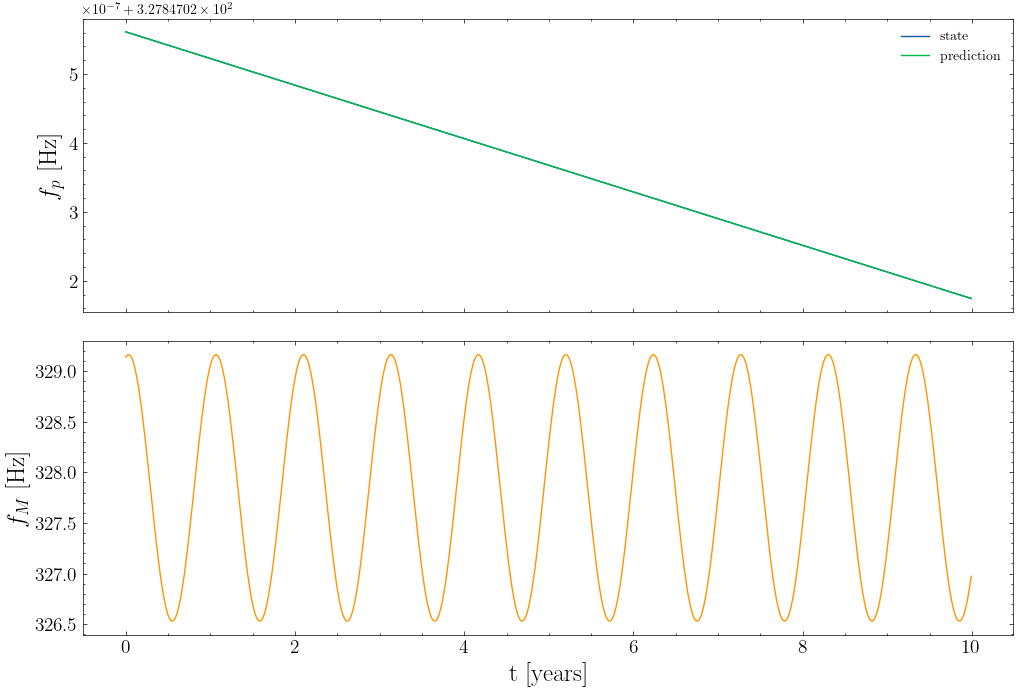

In [185]:
P    = SystemParameters()       #define the system parameters as a class
PTA  = Pulsars(P)               #setup the PTA
data = SyntheticData(PTA,P) #generate some synthetic data


#Define the model 
model = LinearModel

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)
model_likelihood, model_state_predictions = KF.likelihood_and_states(true_parameters)
print("Model likelihood is: ", model_likelihood)
plot_all(PTA.t, data.intrinsic_frequency, data.f_measured, model_state_predictions, 0)


Cool! This works well. The predicted state and the true state are perfectly overlaid.



## 2. Single run example - wrong parameters


Now lets do the same thing again, but this time with the wrong parameters.

Lets just change $\omega$ from its true value of $5 \times 10^{-7}$ Hz to $1 \times 10^{-7}$ Hz.


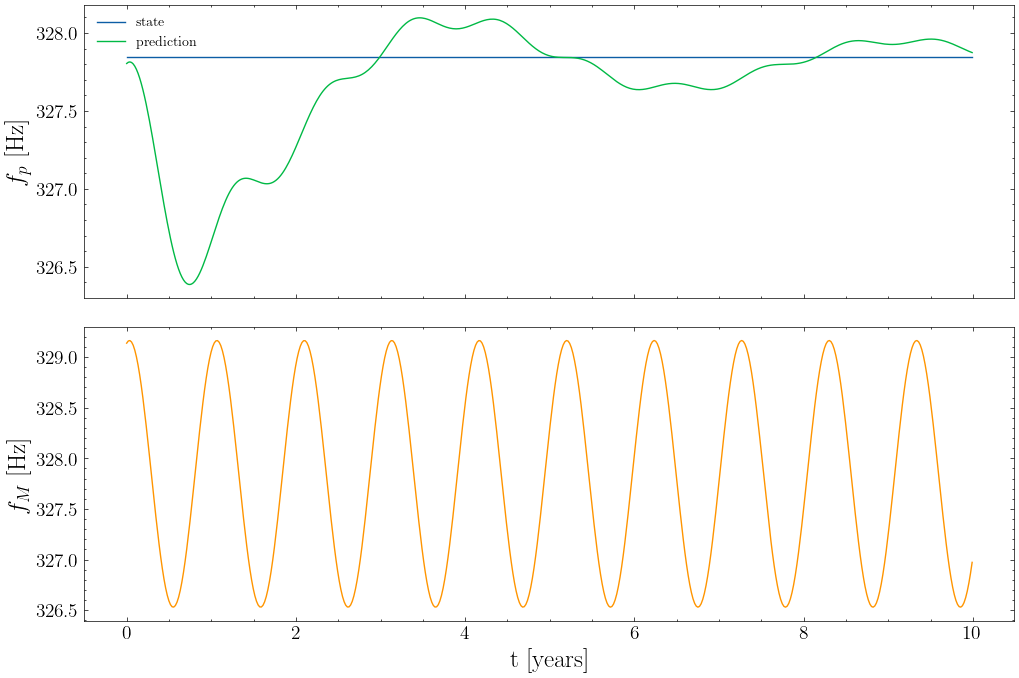

Model likelihood is:  -1.9634879835518677e+24


In [187]:
wrong_parameters = true_parameters.copy()
wrong_parameters["omega_gw"] = 1e-7

model_likelihood,model_predictions = KF.likelihood_and_states(wrong_parameters)
plot_all(PTA.t,data.intrinsic_frequency,data.f_measured,model_predictions,psr_index =0)
print("Model likelihood is: ", model_likelihood)

Now the Kalman filter does a bad job. This is of course expected behaviour. The likelihood value reflects that it did a bad job.

## 3. Kalman filter with nested sampling 

Given the Kalman filter, we want to infer some parameters.

We have discussed different ways we can do this:

* Nested sampling
* Extended state space
* Expectation maximisation


For now we will proceed with NS which is commonly used in astro (...is this a good reason to use it?!)


Different NS tools exist. Again, picking the low hanging fruit we will use Bilby (Dynesty). I did explore NS packages in Julia but unfortunately they look rather immature. For now we will work in Python and sacrifice some speed for ease of exploration.

### 3.1 Example A: Proof of concept ($\omega$ and $h$)

Let's start with a simple, proof of concept example.

We take the full PTA with all the pulsars, and an arbitrary GW system. We will use the same parameters above where the GW strain is aphysically large, $h = 1 \times 10^{-2}$ and the GW angular frequency $\omega = 5 \times 10^{-7}$. For now, we will take all other parameters (e.g. pulsar spindown, GW localization) as known. Can we recover $\omega$ and $h$? This should be an easy case - indeed the frequency and strain amplitudes can almost be read off by eye from the above time series plots!

We set the priors as 

* $\omega$ -  LogUniform(1e-9, 1e-5)

* $h$ - LogUniform(1e-4, 1e0)




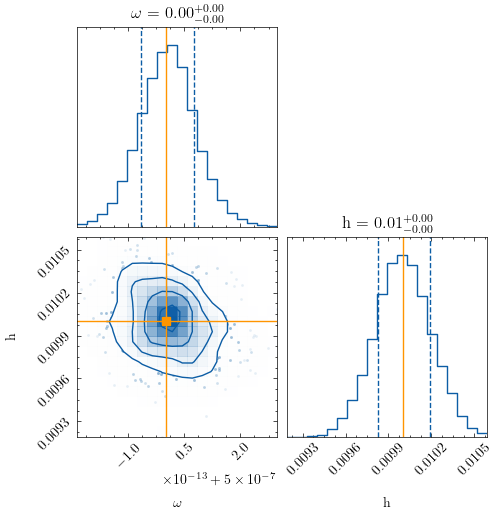

In [134]:
from plotting import plot_custom_corner
path = "../data/nested_sampling/diagonal1_result.json"
labels = [r'$\omega$', r'h']
injection_parameters = [5e-7,1e-2]
axes_scales = ["log", "linear"]
plot_custom_corner(path,labels, injection_parameters,axes_scales)

## 3.2 Example B: a few more parameters, a few less pulsars 












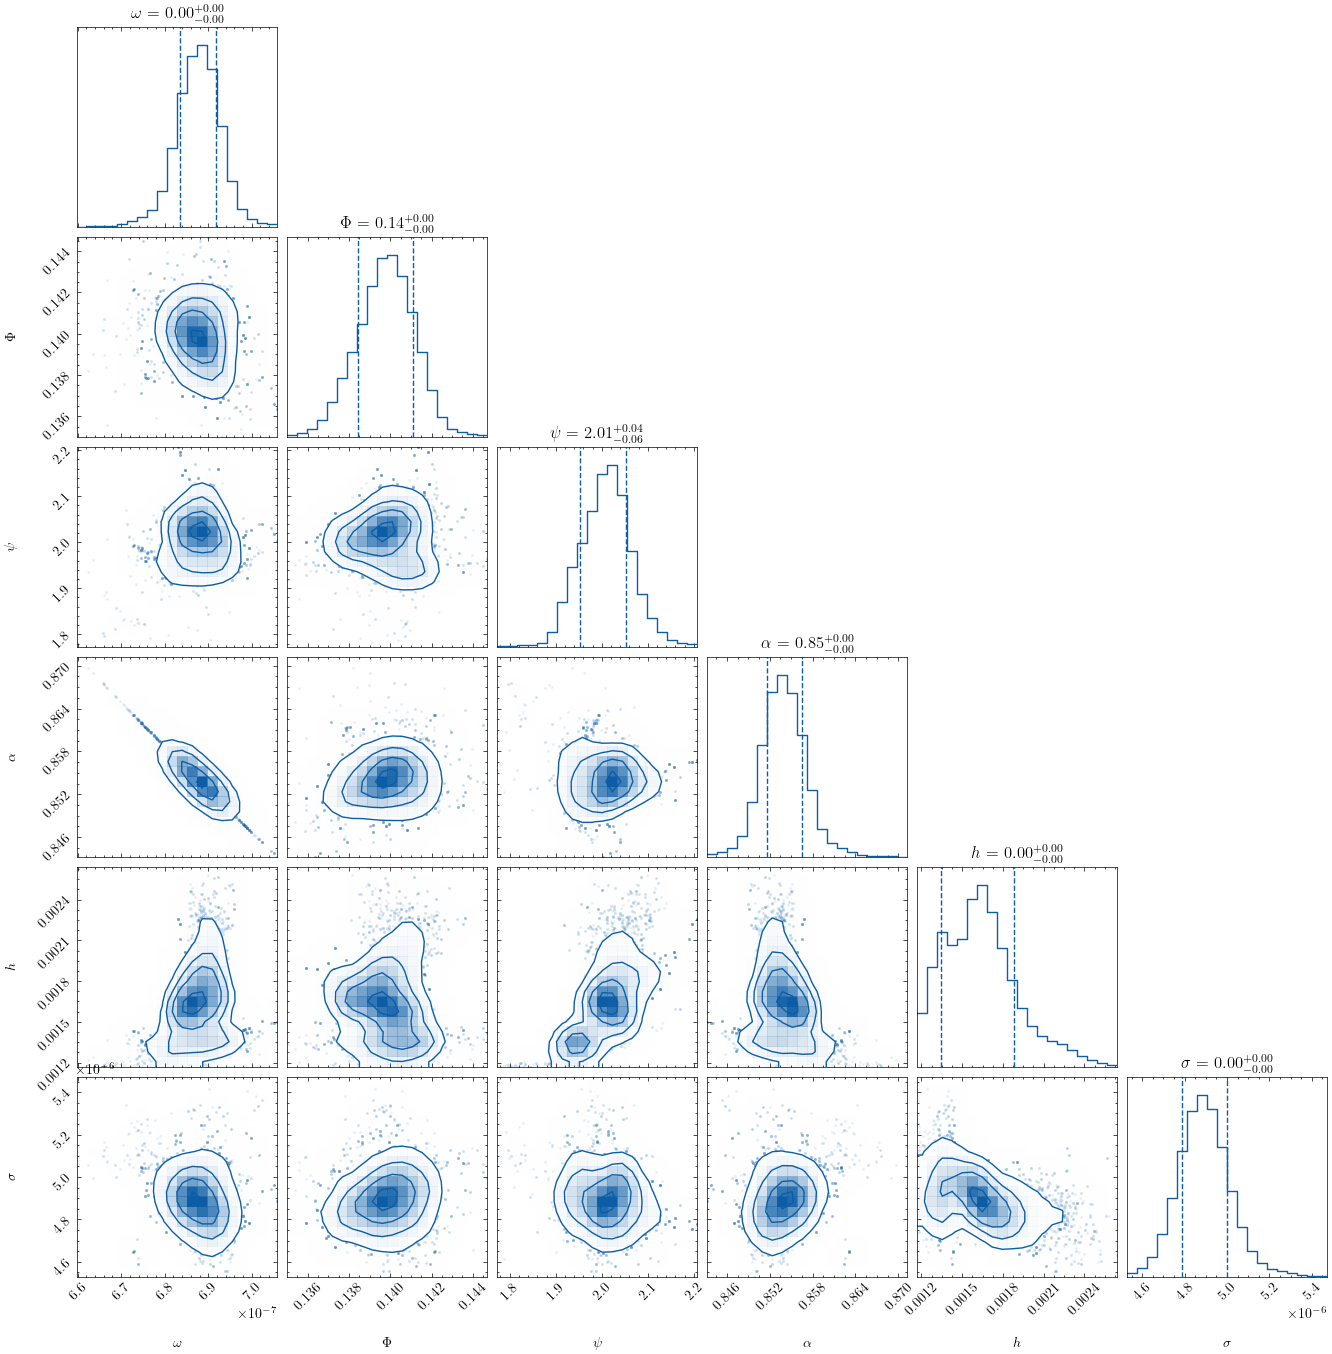

In [163]:
path = "../data/nested_sampling/test49_result.json"
labels = [r"$\omega$",r"$\Phi$",r"$\psi$",r"$\alpha$",r"$h$",r"$\sigma$"]
injection_parameters = [5e-7,0.20,2.50,1.0,1e-2,1e-8]
axes_scales = ["log", "linear","linear","linear","log","log"]
plot_custom_corner(path,labels, injection_parameters,axes_scales)




## 4. Likelihood methods and identifiability 


When we do parameter estimation using either (a) Nested sampling (c.f. Bilby) or (b) expectation maximisation we want to try to maximise the likelihood.

When we run the Kalman filter for a particular set of parameters it returns a likelihood $\mathcal{L}(\hat{\theta}) = \text{KF}(\hat{\theta})$ 

For each of our parameters, what does the $\mathcal{L}(\hat{\theta})$ curve look like (holding other parameters constant)?

0 omega_gw 5e-07
1 psi_gw 2.5
2 iota_gw 1.0
3 delta_gw 1.0
4 alpha_gw 1.0
5 h 0.01
6 f00 327.8470205611185
7 fdot0 -1.227834e-15
8 gamma0 1e-13
9 distance0 181816860005.41092


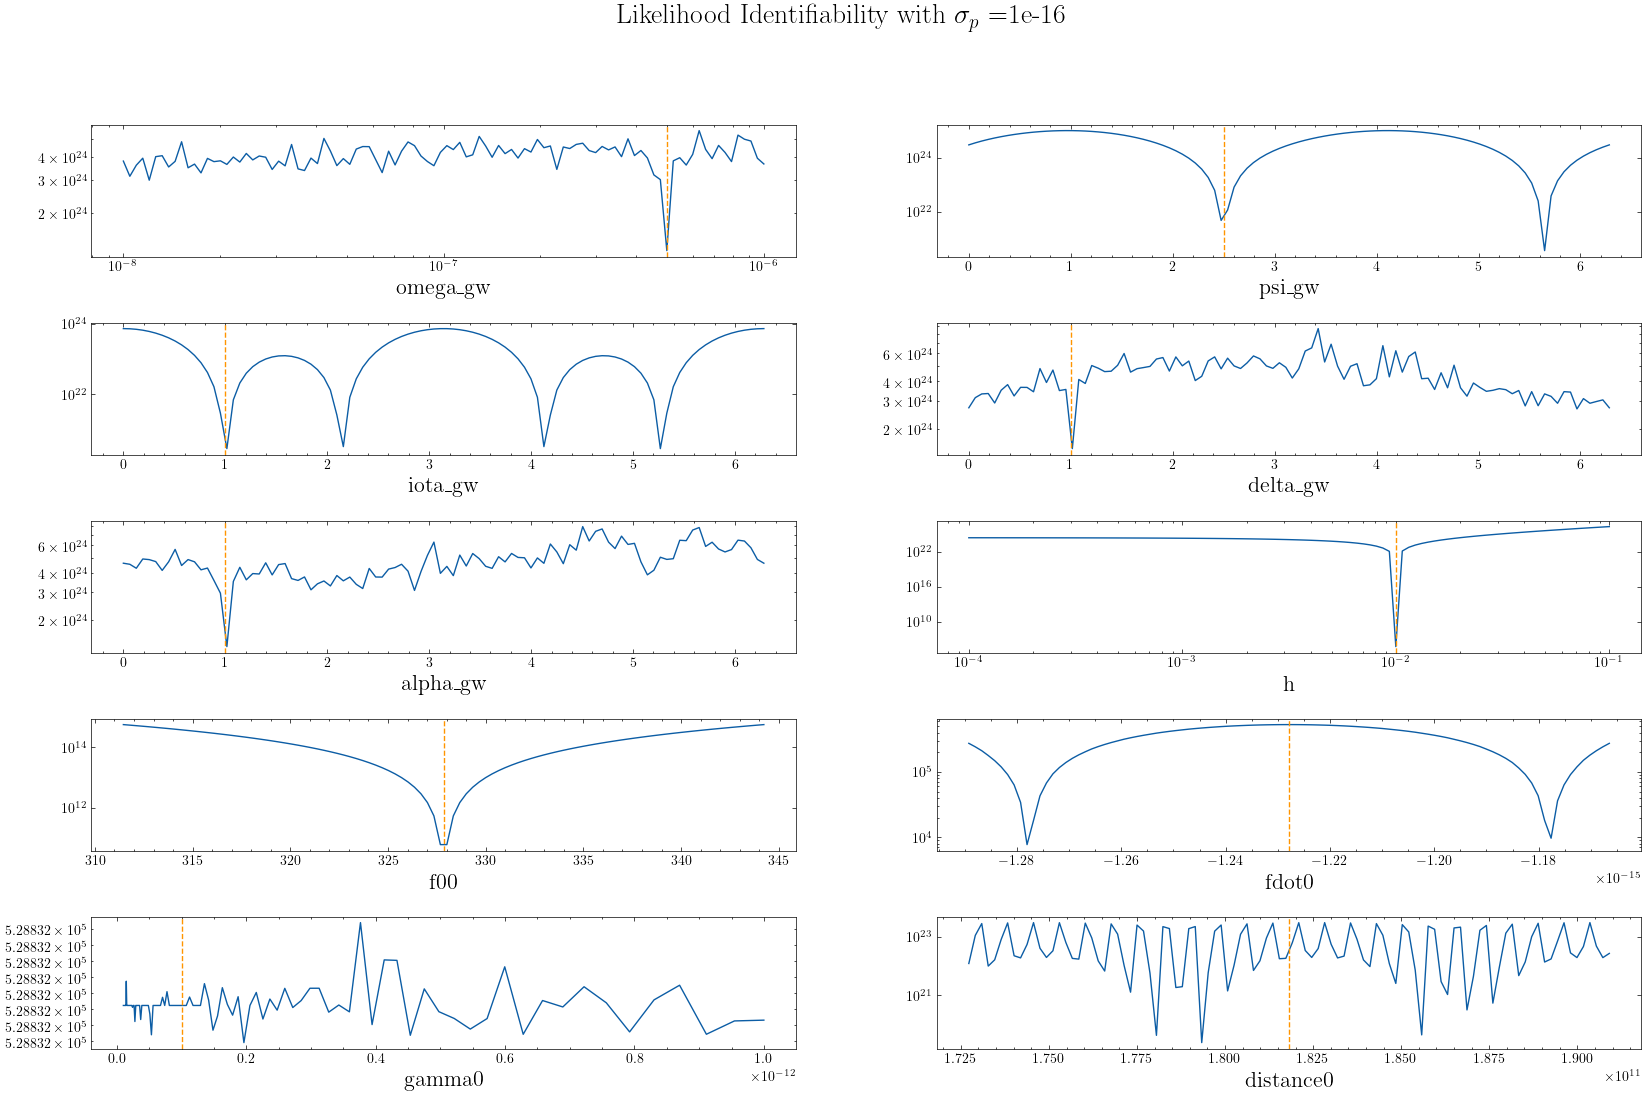

In [181]:
from plotting import likelihoods_over_priors
import numpy as np 


P   = SystemParameters(h=0.01,ι=1.0,δ=1.0,α=1.0)   # define the system parameters 
PTA = Pulsars(P)               # setup the PTA
data = SyntheticData(PTA,P)    # generate some synthetic data


#Define the model 
model = LinearModel

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)


true_parameters = priors_dict(PTA,P)
selected_parameters = ["omega_gw","psi_gw","iota_gw","delta_gw","alpha_gw","h","f00","fdot0","gamma0","distance0"]
parameters_dict = {k: true_parameters[k] for k in selected_parameters}


nsamples = int(1e2)
priors = [np.logspace(-8,-6,nsamples),
          np.linspace(0,2*np.pi,nsamples),
          np.linspace(0,2*np.pi,nsamples),
          np.linspace(0,2*np.pi,nsamples),
          np.linspace(0,2*np.pi,nsamples),
          np.logspace(-4,-1,nsamples),
          np.linspace(true_parameters["f00"]*0.95,true_parameters["f00"]*1.05, nsamples),
          np.linspace(true_parameters["fdot0"]*1.05,true_parameters["fdot0"]*0.95, nsamples), #negative values
          np.logspace(-12,-14,nsamples),
          np.linspace(true_parameters["distance0"]*0.95,true_parameters["distance0"]*1.05, nsamples),
]


likelihoods_over_priors(parameters_dict,priors,PTA,P,KF,sigma_p=P["sigma_p"])




What is we crank up the process noise parameter a bit? i.e. give the KF some more room to wiggle...

0 omega_gw 5e-07
1 psi_gw 2.5
2 iota_gw 1.0
3 delta_gw 1.0
4 alpha_gw 1.0
5 h 0.01
6 f00 327.8470205611185
7 fdot0 -1.227834e-15
8 gamma0 1e-13
9 distance0 181816860005.41092


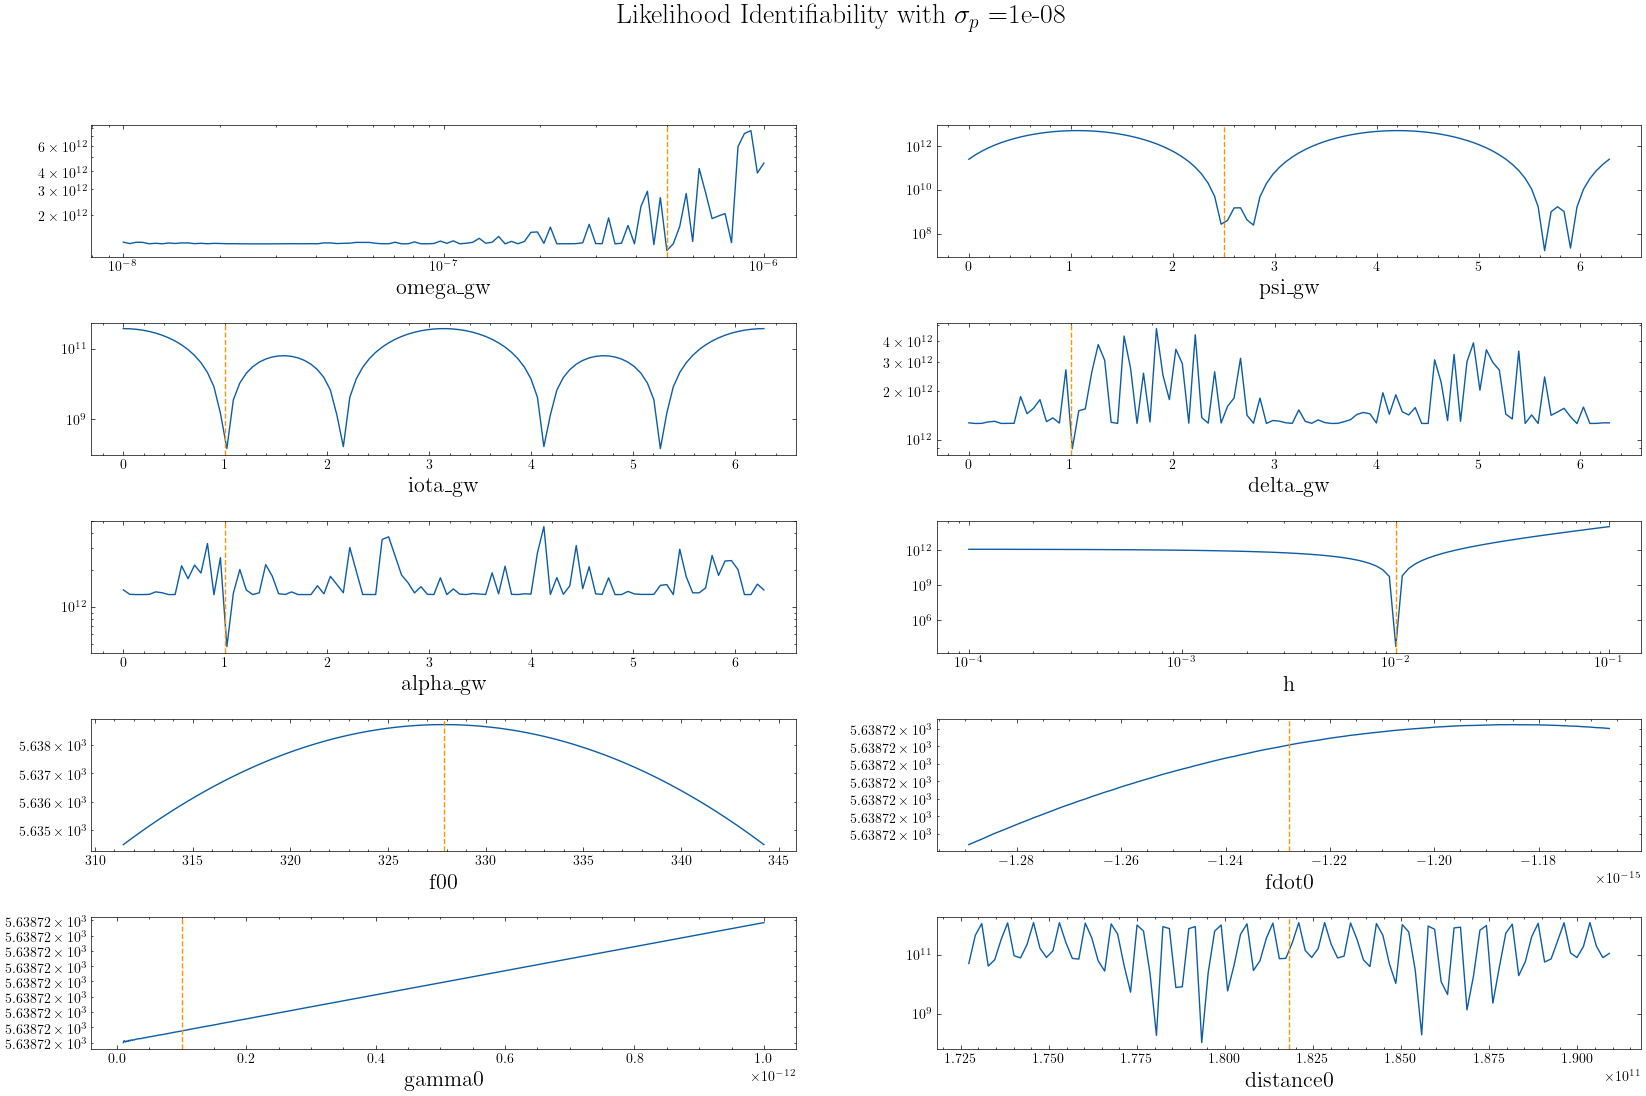

In [141]:
likelihoods_over_priors(parameters_dict,priors,PTA,P,KF,sigma_p=P["sigma_p"]*1e4)

In [32]:
import numpy as np
#from plotting import plot_likelihood

omegas  = np.arange(4e-7,7e-7,1e-7) #consider omegas from 4e-7 to 6e-7. True value is 5 x 10^-7
strains = np.arange(9e-3,1.2e-2,1e-3)    #consider strains from 1e-3 to 1e-1. True value is 1 x 10^-2
freqs = np.arange(320,330,1)    #consider strains from 1e-3 to 1e-1. True value is 1 x 10^-2

likelihoods = np.zeros((len(omegas),len(freqs)))
guessed_parameters = true_parameters.copy()

for i in range(len(omegas)):
    for j in range(len(freqs)):
        #print(i,j)
        guessed_parameters["omega_gw"] = omegas[i]
        #guessed_parameters["h"] = strains[j]
        guessed_parameters["f00"] = freqs[j]

        model_likelihood,model_state_predictions = KF.likelihood_and_states(guessed_parameters)
        likelihoods[i,j] = model_likelihood



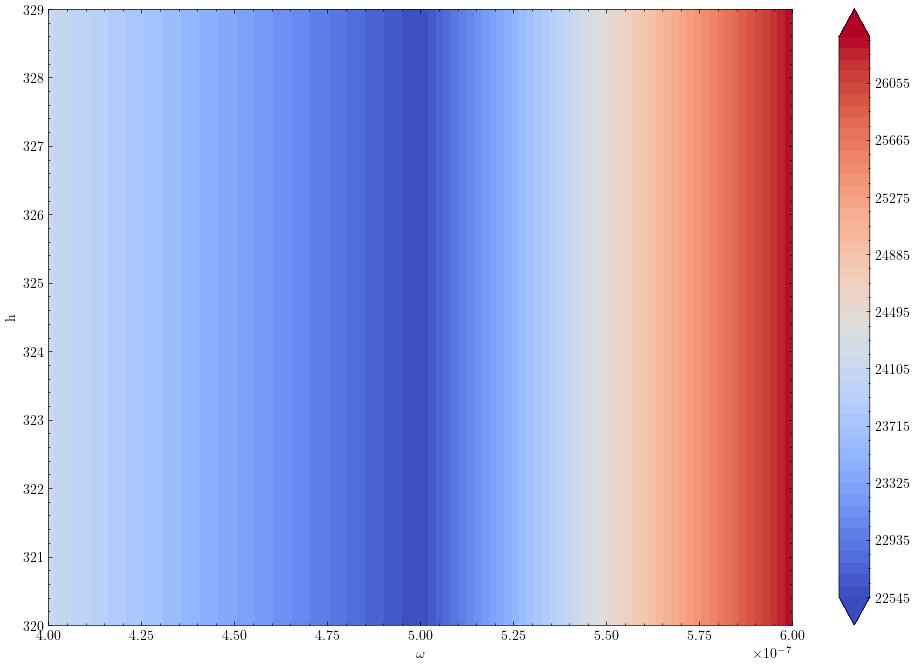

In [34]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import matplotlib.colors as mc



plt.figure(figsize=(12,8))
y,x = np.meshgrid(freqs,omegas)
data = np.abs(likelihoods)
levels = np.linspace(data.min(), data.max(), 50)
CS = plt.contourf(x, y, data, levels=levels, cmap=cm.coolwarm, extend='both',norm=mc.LogNorm(vmin=data.min(), vmax=data.max()))

colorbar = plt.colorbar(CS)
plt.xlabel(r"$\omega$")
plt.ylabel("h")

plt.show()

## 4. Nested sampling 



Dynesty, Bilby etc. 





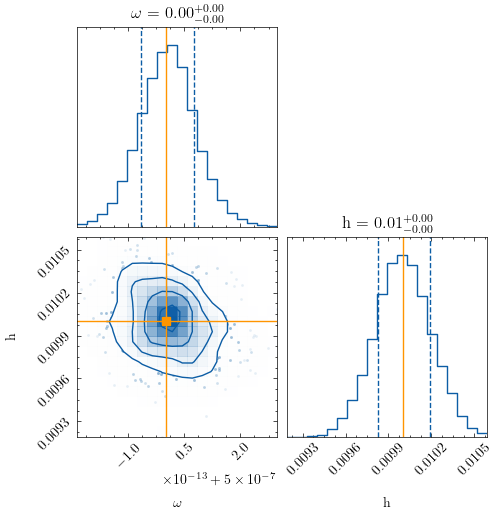

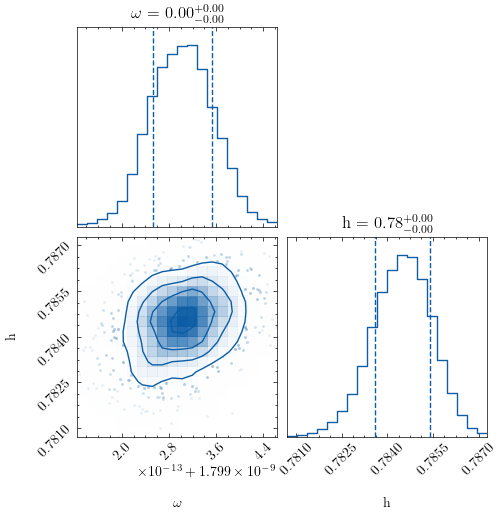

In [53]:
from plotting import plot_custom_corner
path = "../data/nested_sampling/likelihood_test1_result.json"
labels = [r'$\omega$', r'h']
injection_parameters = [5e-7,1e-3]
axes_scales = ["log", "linear"]
plot_custom_corner(path,labels, injection_parameters,axes_scales)

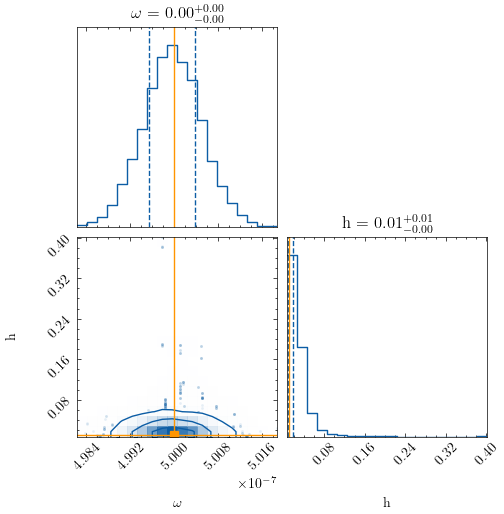

In [112]:
from plotting import plot_custom_corner
path = "../data/nested_sampling/likelihood_test3_result.json"
labels = [r'$\omega$', r'h']
injection_parameters = [5e-7,1e-2]
axes_scales = ["log", "linear"]
plot_custom_corner(path,labels, injection_parameters,axes_scales)

### 4.2 Example B: $\omega$ and pulsar parameters

In [ ]:
### 

## Appendix

## A1. How does $\sigma_p$ influence our results?